In [31]:
import re
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import librosa
import io

from pyspark.sql import SparkSession, Window
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql.types import StringType, ArrayType, StructField, StructType, FloatType, DoubleType, IntegerType

In [2]:
spark = SparkSession.builder.appName("test")\
    .config("spark.driver.memory", "14g")\
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "100")\
    .getOrCreate()

In [3]:
# url = "abfss://sgppipelinesa-bronze@sgppipelinesa.dfs.core.windows.net/"
url = "../include/data/bronze/"
# folder_infos = dbutils.fs.ls(url)

In [4]:
# sample_folder = folder_infos[-1].path
# sample_folder

In [5]:
# sample_folder.strip('/').split('/')[-1]

In [6]:
# type(folder_infos[-1])

In [7]:
# dbutils.fs.ls(folder_infos[-1].path)

In [8]:
file_infos = os.listdir(url)
file_infos

['1028-20100710-hne', '1337ad-20170321-ajg', '1337ad-20170321-tkg']

In [9]:
labels_df = spark.read.format('text')\
    .option("lineSep", "\n")\
    .load(os.path.join(url, "1337ad-20170321-ajg", "etc", "README"))
labels_df.show()

+--------------------+
|               value|
+--------------------+
|    User Name:1337ad|
|                    |
|Speaker Character...|
|                    |
|      Gender: Female|
|    Age Range: Adult|
|        Language: EN|
|Pronunciation dia...|
|                    |
|Recording Informa...|
|                    |
|Microphone make: n/a|
|Microphone type: ...|
|Audio card make: ...|
|Audio card type: ...|
|Audio Recording S...|
|                O/S:|
|                    |
|          File Info:|
|                    |
+--------------------+
only showing top 20 rows



In [10]:
labels_df = spark.read.format("text")\
    .option("lineSep", "\n")\
    .load([os.path.join(url, file_info, "etc", "README") for file_info in file_infos])
# labels_df = spark.read.format("text")\
#     .option("wholeText", "true")\
#     .load([os.path.join(url, file_info, "etc", "README") for file_info in file_infos])
labels_df.show()

+--------------------+
|               value|
+--------------------+
|    User Name:1337ad|
|                    |
|Speaker Character...|
|                    |
|      Gender: Female|
|    Age Range: Adult|
|        Language: EN|
|Pronunciation dia...|
|                    |
|Recording Informa...|
|                    |
|Microphone make: n/a|
|Microphone type: ...|
|Audio card make: ...|
|Audio card type: ...|
|Audio Recording S...|
|                O/S:|
|                    |
|          File Info:|
|                    |
+--------------------+
only showing top 20 rows



In [11]:
labels_df.count()

72

In [12]:
labels_df.withColumn("filePath", F.input_file_name()).show()

+--------------------+--------------------+
|               value|            filePath|
+--------------------+--------------------+
|    User Name:1337ad|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|Speaker Character...|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|      Gender: Female|file:///c:/Users/...|
|    Age Range: Adult|file:///c:/Users/...|
|        Language: EN|file:///c:/Users/...|
|Pronunciation dia...|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|Recording Informa...|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|Microphone make: n/a|file:///c:/Users/...|
|Microphone type: ...|file:///c:/Users/...|
|Audio card make: ...|file:///c:/Users/...|
|Audio card type: ...|file:///c:/Users/...|
|Audio Recording S...|file:///c:/Users/...|
|                O/S:|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|          File Info:|file:///c:/Users/...|
|                    |file:///c:

In [13]:
labels_df.withColumn("filePath", F.input_file_name()).where(
    F.lower(F.col("value")).contains("gender")
).collect()

[Row(value='Gender: Female', filePath='file:///c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1337ad-20170321-ajg/etc/README'),
 Row(value='Gender: Female', filePath='file:///c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1337ad-20170321-tkg/etc/README'),
 Row(value='Gender: Male', filePath='file:///c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1028-20100710-hne/etc/README')]

In [14]:
labels_df = labels_df.withColumn("filePath", F.input_file_name())
labels_df.show()

+--------------------+--------------------+
|               value|            filePath|
+--------------------+--------------------+
|    User Name:1337ad|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|Speaker Character...|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|      Gender: Female|file:///c:/Users/...|
|    Age Range: Adult|file:///c:/Users/...|
|        Language: EN|file:///c:/Users/...|
|Pronunciation dia...|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|Recording Informa...|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|Microphone make: n/a|file:///c:/Users/...|
|Microphone type: ...|file:///c:/Users/...|
|Audio card make: ...|file:///c:/Users/...|
|Audio card type: ...|file:///c:/Users/...|
|Audio Recording S...|file:///c:/Users/...|
|                O/S:|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|          File Info:|file:///c:/Users/...|
|                    |file:///c:

In [15]:
labels_df = labels_df.where(F.lower(F.col("value")).contains("gender"))
labels_df.show()

+--------------+--------------------+
|         value|            filePath|
+--------------+--------------------+
|Gender: Female|file:///c:/Users/...|
|Gender: Female|file:///c:/Users/...|
|  Gender: Male|file:///c:/Users/...|
+--------------+--------------------+



# Clean value columns

In [16]:
labels_df = labels_df.withColumn(
    "value", 
    # extract only the gender of the subject in meta data
    F.regexp_replace(
        F.lower(F.col("value")), 
        r"(gender)|[:;\[\]\t\n\s]+", 
        ""
    )
)
labels_df.show()

+------+--------------------+
| value|            filePath|
+------+--------------------+
|female|file:///c:/Users/...|
|female|file:///c:/Users/...|
|  male|file:///c:/Users/...|
+------+--------------------+



In [17]:
labels_df = labels_df.withColumn(
    "value",
    # sometimes the gender may be in a different language
    # e.g. the 'male' in german may have the string start
    # with 'mä' so we should return male if this is the case
    # and vice versa for females translated to a different
    # language 
    F.when(
        F.col("value").startswith("ma") | F.col("value").startswith("mä"),
        "male"
    ).when(
        F.col("value").startswith("fem") | F.col("value").startswith("wei"),
        "female"
    ).otherwise(
        "unknown"
    )
)
labels_df.show()

+------+--------------------+
| value|            filePath|
+------+--------------------+
|female|file:///c:/Users/...|
|female|file:///c:/Users/...|
|  male|file:///c:/Users/...|
+------+--------------------+



# clean filePath column

In [18]:
labels_df.withColumn(
    "subjectId",
    F.element_at(
        # splits the filepath from 'file:///c:/Users/LARRY/Documents/Scripts/.../bronze/1337ad-20170321-ajg/etc/README
        # to array of the directory tree of the files path e.g. 
        # ['file:', ..., 'Scripts', ..., 'bronze', '<subject id>, 'etc', 'readme']
        # so in order to extract subject id or the file name we have to 
        # get the 3rd to the last element
        F.split(
            F.col("filepath"),
            r"\/"
        ),
        -3
    )
).collect()

[Row(value='female', filePath='file:///c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1337ad-20170321-ajg/etc/README', subjectId='1337ad-20170321-ajg'),
 Row(value='female', filePath='file:///c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1337ad-20170321-tkg/etc/README', subjectId='1337ad-20170321-tkg'),
 Row(value='male', filePath='file:///c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1028-20100710-hne/etc/README', subjectId='1028-20100710-hne')]

In [19]:
labels_df = labels_df.withColumn(
    "subjectId",
    F.element_at(
        # splits the filepath from 'file:///c:/Users/LARRY/Documents/Scripts/.../bronze/1337ad-20170321-ajg/etc/README
        # to array of the directory tree of the files path e.g. 
        # ['file:', ..., 'Scripts', ..., 'bronze', '<subject id>, 'etc', 'readme']
        # so in order to extract subject id or the file name we have to 
        # get the 3rd to the last element
        F.split(
            F.col("filepath"),
            r"\/"
        ),
        -3
    )
)
labels_df.show()

+------+--------------------+-------------------+
| value|            filePath|          subjectId|
+------+--------------------+-------------------+
|female|file:///c:/Users/...|1337ad-20170321-ajg|
|female|file:///c:/Users/...|1337ad-20170321-tkg|
|  male|file:///c:/Users/...|  1028-20100710-hne|
+------+--------------------+-------------------+



In [20]:
# # what I want to do is list the files get all the file names in the bronze 
# # container, which will give me a list, and then use that list to concurrently
# # list the files inside these list of directories
# def load_labels(DIR, folder_infos):
#     def helper(folder_info):
#         try:
#             # remove trailing backslash
#             folder = folder_info.path.strip('/').split('/')[-1]
#             file_path = os.path.join(DIR, folder, "etc", "README")
            
#             print(file_path)
#             with open(file_path, "r") as file:
#                 lines = [line for line in file.readlines() if "gender" in line.lower()]
#                 file.close()

#             print(lines)

#             # extract only the gender of the subject in meta data
#             # print(lines[0].lower())
#             string = re.sub(r"(gender)", "", lines[0].lower())
#             string = re.sub(r"[:;\[\]\t\n\s]", "", string)

#             if string:
#                 gender = string
#                 if gender.startswith("ma") or gender.startswith("mä"):
#                     return folder, string, "male"
#                 elif gender.startswith("fem") or gender.startswith("wei"):
#                     return folder, string, "female"
#                 else:
#                     return folder, string, "unknown"
            
#         except IndexError:
#             return folder, "unknown", "unknown"
        
#         except FileNotFoundError:
#             return folder, "unknown", "unknown"

#     with ThreadPoolExecutor(max_workers=5) as exe:
#         subjects_labels = list(exe.map(helper, folder_infos))
        
        
#     return subjects_labels

In [67]:
def load_audio(DIR: str, folders: list, hertz=16000):
    """
    loads audio signals from each .wav file of each subject
    """

    def helper(folder):
    # for folder in folders:
        try:
            wavs_dir = os.path.join(DIR, folder, "wav")
            path_to_wavs = os.listdir(wavs_dir)

        # this is if a .wav file is not used as a directory so 
        # try flac 
        except FileNotFoundError:
            wavs_dir = os.path.join(DIR, folder, "flac")
            path_to_wavs = os.listdir(wavs_dir)

        finally:
            # create storage for list of signals to all be 
            # concatenated later
            ys = []

            # create figure, and axis
            # fig, axes = plt.subplots(nrows=len(path_to_wavs), ncols=1, figsize=(12, 30))
            
            for index, wav in enumerate(path_to_wavs):

                wav_path = os.path.join(wavs_dir, wav)
                # print(wav_path)

                # each .wav file has a sampling frequency is 16000 hertz 
                y, sr = librosa.load(wav_path, sr=hertz)

                # audio recordings can have different length
                print(f"shape of audio signals {y.shape}")
                print(f"sampling rate of audio signals after interpolation: {sr}")

                # top_db is set to 20 representing any signal below
                # 20 decibels will be considered silence
                y_trimmed, _ = librosa.effects.trim(y, top_db=20)

                # append y to ys 
                ys.extend(y_trimmed.tolist())

            # # concatenate all audio signals into one final signal as 
            # # this is all anyway recorded in the voice of the same gender
            # final = np.concatenate(ys, axis=0)
            # print(f"shape of final signal: {final.shape}")
            
            # print(f"shape of signal: {y.shape}")
            # print(f"shape of trimmed signal: {y_trimmed.shape}")
            # print(f"sampling rate: {sr}")
            # librosa.display.waveshow(final, alpha=0.5)

            # plt.tight_layout()
            # plt.show()

            return folder, ys
        
    # concurrently load .wav files and trim  each .wav files
    # audio signal and combine into one signal for each subject 
    with ThreadPoolExecutor(max_workers=5) as exe:
        signals = list(exe.map(helper, folders))
        
    return signals

In [68]:
signals = load_audio(url, file_infos)

shape of audio signals (100000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (74000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (76000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (90000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (86000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (110000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (68000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (102000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (104000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (96000,)
sampling rate of audio signals after interpolation: 16000
shape of audio signals (82000,)
sampling rate of audio signals after interpolation: 16000
shape 

In [69]:
signals

[('1028-20100710-hne',
  [-0.01312255859375,
   -0.013031005859375,
   -0.0128173828125,
   -0.012481689453125,
   -0.012115478515625,
   -0.011444091796875,
   -0.011077880859375,
   -0.01031494140625,
   -0.009613037109375,
   -0.008941650390625,
   -0.008697509765625,
   -0.008331298828125,
   -0.008026123046875,
   -0.00787353515625,
   -0.007659912109375,
   -0.007049560546875,
   -0.006805419921875,
   -0.006561279296875,
   -0.007171630859375,
   -0.007110595703125,
   -0.0064697265625,
   -0.0062255859375,
   -0.005706787109375,
   -0.005462646484375,
   -0.0052490234375,
   -0.004486083984375,
   -0.00335693359375,
   -0.002777099609375,
   -0.002197265625,
   -0.001861572265625,
   -0.000885009765625,
   0.0,
   0.000701904296875,
   0.001068115234375,
   0.001953125,
   0.00299072265625,
   0.003509521484375,
   0.004547119140625,
   0.0062255859375,
   0.0068359375,
   0.007476806640625,
   0.00775146484375,
   0.00860595703125,
   0.009796142578125,
   0.009918212890625,
 

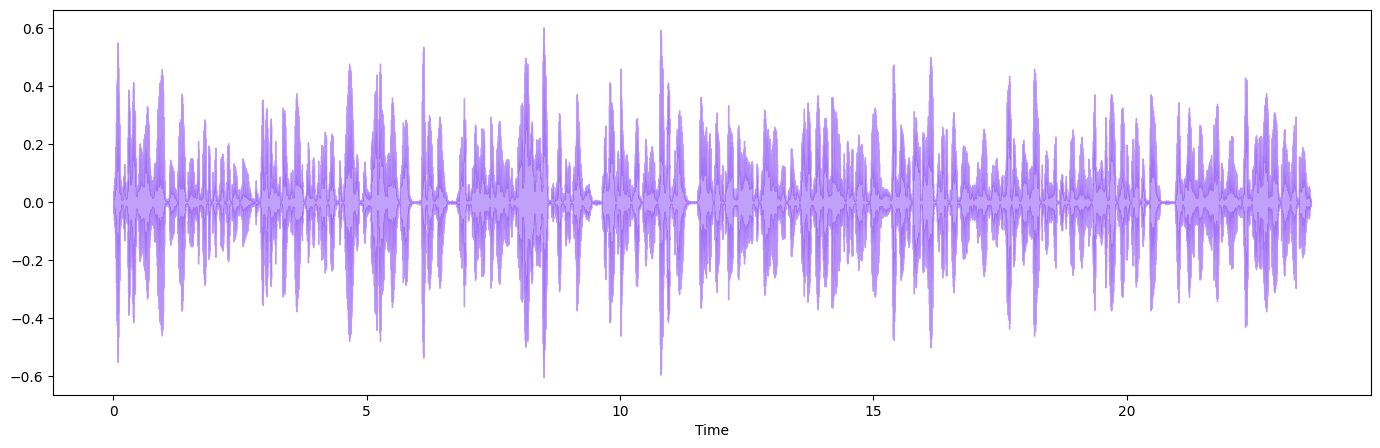

In [71]:
fig = plt.figure(figsize=(17, 5))
librosa.display.waveshow(np.array(signals[0][-1]), alpha=0.5, color="#8442f5")
plt.show()

# Loading audio signals
need some way to concurrently build this array:
`["url/<subject k>/wav/*.wav", "url/<subject k>/wav/*.wav", "url/<subject k>/flac/*.flac"]`


In [52]:
def collect_subjects_wav_paths(DIR: str, folders: list) -> list[str]:
    """
    collects all the paths of wav files of each subject and
    forms a wildcard out of it that a spark session can use
    to concurrent read the files into a spark dataframe 
    """
    def helper(folder):
        # for folder in folders:
        try:
            wav_paths = os.path.join(DIR, folder, "wav", "*.wav")

        # this is if a .wav file is not used as a directory so 
        # try flac 
        except FileNotFoundError:
            wav_paths = os.path.join(DIR, folder, "flac", "*.flac")

        return wav_paths

    with ThreadPoolExecutor(max_workers=5) as exe:
        subjects_wav_paths = list(exe.map(helper, folders) )

    return subjects_wav_paths

In [53]:
subjects_wav_paths = collect_subjects_wav_paths(url, file_infos)
subjects_wav_paths

['../include/data/bronze/1028-20100710-hne\\wav\\*.wav',
 '../include/data/bronze/1337ad-20170321-ajg\\wav\\*.wav',
 '../include/data/bronze/1337ad-20170321-tkg\\wav\\*.wav']

In [61]:
signals_df = spark.read.format("binaryFile").load(subjects_wav_paths)
signals_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/c:/Users/LA...|2017-03-24 14:03:27|220044|[52 49 46 46 84 5...|
|file:/c:/Users/LA...|2010-07-20 15:10:57|212044|[52 49 46 46 44 3...|
|file:/c:/Users/LA...|2010-07-20 15:10:57|208044|[52 49 46 46 A4 2...|
|file:/c:/Users/LA...|2017-03-24 14:03:27|208044|[52 49 46 46 A4 2...|
|file:/c:/Users/LA...|2010-07-20 15:10:57|204044|[52 49 46 46 04 1...|
|file:/c:/Users/LA...|2017-03-24 14:03:27|204044|[52 49 46 46 04 1...|
|file:/c:/Users/LA...|2010-07-20 15:10:57|200044|[52 49 46 46 64 0...|
|file:/c:/Users/LA...|2017-03-24 14:03:27|192044|[52 49 46 46 24 E...|
|file:/c:/Users/LA...|2017-03-24 14:03:28|192044|[52 49 46 46 24 E...|
|file:/c:/Users/LA...|2010-07-20 15:10:57|188044|[52 49 46 46 84 D...|
|file:/c:/Users/LA...|2017-03-24 14:03:28|188044|[52 49 46 46 84 D...|
|file:

In [62]:
signals_df = signals_df.withColumn(
    "subjectId",
    F.element_at(
        # splits the filepath from 'file:///c:/Users/LARRY/Documents/Scripts/.../bronze/1337ad-20170321-ajg/etc/README
        # to array of the directory tree of the files path e.g. 
        # ['file:', ..., 'Scripts', ..., 'bronze', '<subject id>, 'etc', 'readme']
        # so in order to extract subject id or the file name we have to 
        # get the 3rd to the last element
        F.split(
            F.col("path"),
            r"\/"
        ),
        -3
    )
)
signals_df.show()

+--------------------+-------------------+------+--------------------+-------------------+
|                path|   modificationTime|length|             content|          subjectId|
+--------------------+-------------------+------+--------------------+-------------------+
|file:/c:/Users/LA...|2017-03-24 14:03:27|220044|[52 49 46 46 84 5...|1337ad-20170321-ajg|
|file:/c:/Users/LA...|2010-07-20 15:10:57|212044|[52 49 46 46 44 3...|  1028-20100710-hne|
|file:/c:/Users/LA...|2010-07-20 15:10:57|208044|[52 49 46 46 A4 2...|  1028-20100710-hne|
|file:/c:/Users/LA...|2017-03-24 14:03:27|208044|[52 49 46 46 A4 2...|1337ad-20170321-tkg|
|file:/c:/Users/LA...|2010-07-20 15:10:57|204044|[52 49 46 46 04 1...|  1028-20100710-hne|
|file:/c:/Users/LA...|2017-03-24 14:03:27|204044|[52 49 46 46 04 1...|1337ad-20170321-tkg|
|file:/c:/Users/LA...|2010-07-20 15:10:57|200044|[52 49 46 46 64 0...|  1028-20100710-hne|
|file:/c:/Users/LA...|2017-03-24 14:03:27|192044|[52 49 46 46 24 E...|1337ad-20170321-ajg|

In [63]:
signals_df.orderBy("path").select("path").collect()

[Row(path='file:/c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1028-20100710-hne/wav/ar-01.wav'),
 Row(path='file:/c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1028-20100710-hne/wav/ar-02.wav'),
 Row(path='file:/c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1028-20100710-hne/wav/ar-03.wav'),
 Row(path='file:/c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1028-20100710-hne/wav/ar-04.wav'),
 Row(path='file:/c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1028-20100710-hne/wav/ar-05.wav'),
 Row(path='file:/c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predictor/include/data/bronze/1028-20100710-hne/wav/ar-06.wav'),
 Row(path='file:/c:/Users/LARRY/Documents/Scripts/data-engineering-path/signal-gender-predicto

In [64]:
signals_df = signals_df.drop(*["modificationTime", "length"])
signals_df.show()

+--------------------+--------------------+-------------------+
|                path|             content|          subjectId|
+--------------------+--------------------+-------------------+
|file:/c:/Users/LA...|[52 49 46 46 84 5...|1337ad-20170321-ajg|
|file:/c:/Users/LA...|[52 49 46 46 44 3...|  1028-20100710-hne|
|file:/c:/Users/LA...|[52 49 46 46 A4 2...|  1028-20100710-hne|
|file:/c:/Users/LA...|[52 49 46 46 A4 2...|1337ad-20170321-tkg|
|file:/c:/Users/LA...|[52 49 46 46 04 1...|  1028-20100710-hne|
|file:/c:/Users/LA...|[52 49 46 46 04 1...|1337ad-20170321-tkg|
|file:/c:/Users/LA...|[52 49 46 46 64 0...|  1028-20100710-hne|
|file:/c:/Users/LA...|[52 49 46 46 24 E...|1337ad-20170321-ajg|
|file:/c:/Users/LA...|[52 49 46 46 24 E...|1337ad-20170321-tkg|
|file:/c:/Users/LA...|[52 49 46 46 84 D...|  1028-20100710-hne|
|file:/c:/Users/LA...|[52 49 46 46 84 D...|1337ad-20170321-ajg|
|file:/c:/Users/LA...|[52 49 46 46 44 B...|1337ad-20170321-tkg|
|file:/c:/Users/LA...|[52 49 46 46 A4 A.

In [54]:
test_content = signals_df.limit(1).collect()[-1].content
test_content

bytearray(b'RIFF\x84[\x03\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data`[\x03\x00\xcd\xff\xa3\xff\xb9\xff\xb5\xff\xb5\xff\xb1\xff\xb1\xff\xae\xff\xb6\xff\xb5\xff\xb4\xff\xb0\xff\xb0\xff\xb8\xff\xb6\xff\xb3\xff\xb2\xff\xaf\xff\xaf\xff\xb7\xff\xb4\xff\xb3\xff\xb2\xff\xb4\xff\xb9\xff\xbb\xff\xb8\xff\xbb\xff\xb1\xff\xb6\xff\xb9\xff\xb9\xff\x08\x00*\x00#\x00&\x00#\x00!\x00\x1f\x00!\x00\x1d\x00\x1c\x00\x1d\x00\x19\x00\x19\x00\x1e\x00\x18\x00 \x00\x17\x00\x12\x00\x1f\x00\x17\x00\x1b\x00\x18\x00\x18\x00\x19\x00\x11\x00\x18\x00\x1c\x00\x17\x00\x13\x00\x16\x00\x17\x00\x13\x00\x16\x00\x14\x00\x17\x00\x1b\x00\x1b\x00\x1d\x00#\x00"\x00$\x00\x1e\x00\x1e\x00#\x00 \x00(\x00$\x00*\x00$\x00#\x00-\x00/\x00-\x00/\x008\x002\x000\x004\x002\x006\x00<\x009\x00?\x00;\x007\x00:\x00B\x00G\x00I\x00K\x00I\x00J\x00N\x00U\x00V\x00V\x00`\x00b\x00^\x00e\x00a\x00Y\x00g\x00f\x00f\x00g\x00h\x00k\x00h\x00l\x00o\x00r\x00n\x00u\x00v\x00u\x00u\x00v\x00~\x00~\x00\x7f\x00|\x00\x81\x0

In [40]:
test_stream = io.BytesIO(test_content)
test_stream

In [41]:
librosa.load(test_stream, sr=8000)

(array([-0.00152454, -0.00255733, -0.00216258, ..., -0.0037076 ,
        -0.00345337, -0.00386626], shape=(55000,), dtype=float32),
 8000)

In [65]:
# Define a UDF to load audio with librosa
@F.udf(returnType=ArrayType(FloatType()))
def load_audio_with_librosa(content):
    if content is None:
        return None

    try:
        # Create a file-like object from the binary content
        audio_buffer = io.BytesIO(content)
        # Load audio using librosa
        y, sr = librosa.load(audio_buffer, sr=None) # sr=None to preserve original sample rate
        
        # top_db is set to 20 representing any signal below
        # 20 decibels will be considered silence
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)

        # Convert numpy array to list for Spark
        return y_trimmed.tolist()
    
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

In [66]:
signals_df = signals_df.withColumn("signals", load_audio_with_librosa("content"))
signals_df.show()

+--------------------+--------------------+-------------------+--------------------+
|                path|             content|          subjectId|             signals|
+--------------------+--------------------+-------------------+--------------------+
|file:/c:/Users/LA...|[52 49 46 46 84 5...|1337ad-20170321-ajg|[-0.0010375977, -...|
|file:/c:/Users/LA...|[52 49 46 46 44 3...|  1028-20100710-hne|[-0.0054626465, -...|
|file:/c:/Users/LA...|[52 49 46 46 A4 2...|  1028-20100710-hne|[-0.0074768066, -...|
|file:/c:/Users/LA...|[52 49 46 46 A4 2...|1337ad-20170321-tkg|[0.0015869141, 0....|
|file:/c:/Users/LA...|[52 49 46 46 04 1...|  1028-20100710-hne|[-0.0020141602, -...|
|file:/c:/Users/LA...|[52 49 46 46 04 1...|1337ad-20170321-tkg|[-2.4414062E-4, 8...|
|file:/c:/Users/LA...|[52 49 46 46 64 0...|  1028-20100710-hne|[-0.013122559, -0...|
|file:/c:/Users/LA...|[52 49 46 46 24 E...|1337ad-20170321-ajg|[0.0012817383, 0....|
|file:/c:/Users/LA...|[52 49 46 46 24 E...|1337ad-20170321-tkg|[3

In [60]:
signals_df.groupBy("subjectId").agg(F.collect_list(F.col("signals"))).show()

+-------------------+---------------------+
|          subjectId|collect_list(signals)|
+-------------------+---------------------+
|1337ad-20170321-ajg| [[-0.0010375977, ...|
|1337ad-20170321-tkg| [[0.0015869141, 0...|
|  1028-20100710-hne| [[-0.0054626465, ...|
+-------------------+---------------------+

